In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
def smoothed_sample_anomalies(scores, halflife=2):
    '''
        Exponential weighted sample likelihood.
        Args:
            scores - result of running ClusterAD-DataSample algorithm for samples
            halflife -  size of smoothing window.
    '''
    frames = [pd.DataFrame(series) for series in scores]
    return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])

In [8]:
def extract_anomaly_target(frame, frame_period, halflife,
                            horizont, top=0.01, more_info=False, **kwargs):
    '''
        Extract target anomalies from 2-dim frame.
        Args:
            frame - 2-dim pandas Dataframe
            frame_period - period for division into group of independent series
            halflife - size of smoothing window
            top - anomaly bound
            more_info - return more important objects if True
    '''
    import sys
    from copy import deepcopy
    import gaussian_mixture_anomaly_detection
    assert len(frame.shape) == 2
    assert isinstance(frame, pd.DataFrame)
    frame = np.array(deepcopy(frame))
    start_size = frame.shape[0]
    if frame.shape[0] % frame_period != 0:
        print("remove last elements until period", file=sys.stderr)
        for _ in np.arange(frame.shape[0] % frame_period):
            frame = np.delete(frame, -1, 0)

    data = frame.reshape(-1, frame_period, frame.shape[1])
    detector = gaussian_mixture_anomaly_detection.GaussianMixtureInTimeAnomalyDetector(**kwargs)
    scores = detector.fit(data)
    smoothed_scores = smoothed_sample_anomalies(scores, halflife)
    anomalies, treshold = detector.find_anomalies(smoothed_scores, anomaly_top=top)
    anomaly_indexes = [t[1][0] * frame_period + t[1][1] for t in anomalies]
    if horizont > 0:
        all_anomalies = set()
        for a in anomaly_indexes:
            for l in np.arange(horizont):
                all_anomalies.add(max(a - l, 0))
    else:
        all_anomalies = anomaly_indexes

    targets = np.zeros(start_size)

    for a in all_anomalies:
        targets[a] = 1

    if more_info:
        return targets, scores, smoothed_scores, treshold
    else:
        return targets

In [27]:
def plot_events(events, features, names):
    if len(events) > 1:
        events = events[0]
    if len(features.shape) == 1:
        features = [features]
    assert(len(names) == len(features))
    for name, f in zip(names, features):
        plt.figure(figsize=(10,8))
        plt.title(name)
        plt.plot(f, color='blue')
        plt.plot(np.where(events)[0],f[np.where(events)[0]],'*', color='red')
        plt.grid(True)
        plt.show()

In [73]:
def merge_frames(big_f, small_f, rname):
    good_small_inds = np.array(small_f.index)
    big_idx = np.array(big_f.index)
    cur = 0
    for i, ind in enumerate(good_small_inds):
        while cur < len(big_idx) and big_idx[cur] < ind:
            cur += 1
        if cur == len(big_idx):
            break
        good_small_inds[i] = big_idx[cur]
        limit = i + 1
    plt.plot(good_small_inds)
    plt.plot(big_idx)
    small_f = small_f.iloc[:limit]    
    small_f.index = good_small_inds[:limit]
    return big_f.join(small_f,rsuffix='_{}'.format(rname), how='inner')

In [11]:
names = ['Stove1', 'Bench1', 'Ceiling1', 'Doorway1', 'Floor1', 'Outdoor1']

In [12]:
pools = [pd.read_csv('data/{}.csv'.format(name), index_col='timestamps') for name in names]

In [13]:
pools = [p.sort_index() for p in pools]

In [14]:
[p.shape for p in pools]

[(133645, 2), (133622, 2), (54186, 16), (54011, 16), (54170, 16), (54243, 16)]

In [16]:
pools[0].index

Int64Index([1542924742034, 1542924743033, 1542924744047, 1542924745233,
            1542924746088, 1542924747108, 1542924748148, 1542924749168,
            1542924750187, 1542924750930,
            ...
            1543068713411, 1543068714400, 1543068715401, 1543068716401,
            1543068717497, 1543068718701, 1543068719500, 1543068720409,
            1543068721402, 1543068722403],
           dtype='int64', name='timestamps', length=133645)

In [17]:
pools[1].index

Int64Index([1542924742055, 1542924743055, 1542924744068, 1542924745255,
            1542924746109, 1542924747129, 1542924748444, 1542924749189,
            1542924750209, 1542924750951,
            ...
            1543067406215, 1543067407215, 1543067408216, 1543067409416,
            1543067410216, 1543067411223, 1543067412214, 1543067413214,
            1543067414327, 1543067415527],
           dtype='int64', name='timestamps', length=133622)

In [18]:
for i, p in enumerate(pools):
    l = np.where(p.index > 1.54297 * 1e12)
    pools[i] = p.iloc[l]

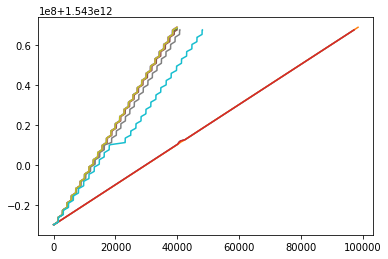

In [74]:
bfp = pools[0]
for name, p in zip(names[1:], pools[1:]):
    bfp = merge_frames(bfp, p, name)

In [75]:
bfp.columns

Index(['Water vapor saturation pressure', 'Temperature',
       'Carbon Dioxide concentration', 'Temperature_Bench1',
       'Water vapor saturation pressure_Ceiling1', 'Absolute humidity at NTP',
       'Wet-bulb temperature', 'Dew point temperature', 'Relative humidity',
       'Enthalpy', 'Mixing ratio', 'Dew point temperature difference',
       'Water concentration', 'Temperature_Ceiling1',
       'Dew point temperature at 1 atm', 'Dew/frost point temperature',
       'Water vapor pressure', 'Dew/frost point temperature at 1 atm',
       'Absolute humidity', 'Water mass fraction',
       'Water vapor saturation pressure_Doorway1',
       'Absolute humidity at NTP_Doorway1', 'Wet-bulb temperature_Doorway1',
       'Dew point temperature_Doorway1', 'Relative humidity_Doorway1',
       'Enthalpy_Doorway1', 'Mixing ratio_Doorway1',
       'Dew point temperature difference_Doorway1',
       'Water concentration_Doorway1', 'Temperature_Doorway1',
       'Dew point temperature at 1 atm_D

In [93]:
bfp.to_csv('data/bfp6.csv')

In [79]:
g = extract_anomaly_target(bfp, frame_period=60, halflife=5, horizont=0, top=0.01, more_info=True, n_components=300)

remove last elements until period
Sample clusters fitting - OK.
100%|██████████| 1144/1144 [06:59<00:00,  2.73it/s]
Probabilities memorization - OK.


KeyboardInterrupt: 

In [76]:
list(enumerate(bfp.columns))

[(0, 'Water vapor saturation pressure'),
 (1, 'Temperature'),
 (2, 'Carbon Dioxide concentration'),
 (3, 'Temperature_Bench1'),
 (4, 'Water vapor saturation pressure_Ceiling1'),
 (5, 'Absolute humidity at NTP'),
 (6, 'Wet-bulb temperature'),
 (7, 'Dew point temperature'),
 (8, 'Relative humidity'),
 (9, 'Enthalpy'),
 (10, 'Mixing ratio'),
 (11, 'Dew point temperature difference'),
 (12, 'Water concentration'),
 (13, 'Temperature_Ceiling1'),
 (14, 'Dew point temperature at 1 atm'),
 (15, 'Dew/frost point temperature'),
 (16, 'Water vapor pressure'),
 (17, 'Dew/frost point temperature at 1 atm'),
 (18, 'Absolute humidity'),
 (19, 'Water mass fraction'),
 (20, 'Water vapor saturation pressure_Doorway1'),
 (21, 'Absolute humidity at NTP_Doorway1'),
 (22, 'Wet-bulb temperature_Doorway1'),
 (23, 'Dew point temperature_Doorway1'),
 (24, 'Relative humidity_Doorway1'),
 (25, 'Enthalpy_Doorway1'),
 (26, 'Mixing ratio_Doorway1'),
 (27, 'Dew point temperature difference_Doorway1'),
 (28, 'Water co

In [80]:
good_features = [3, 2, 13]

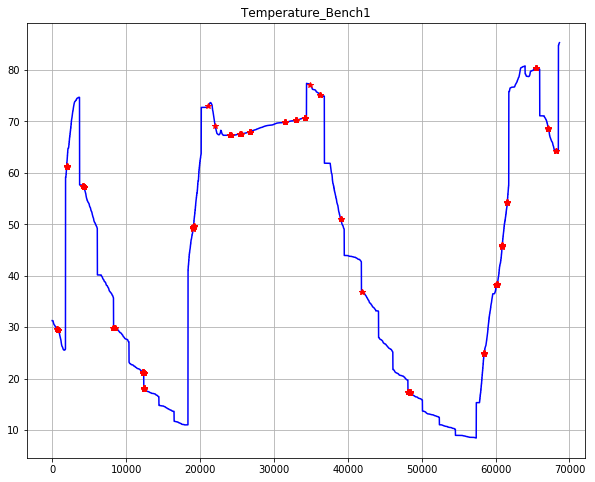

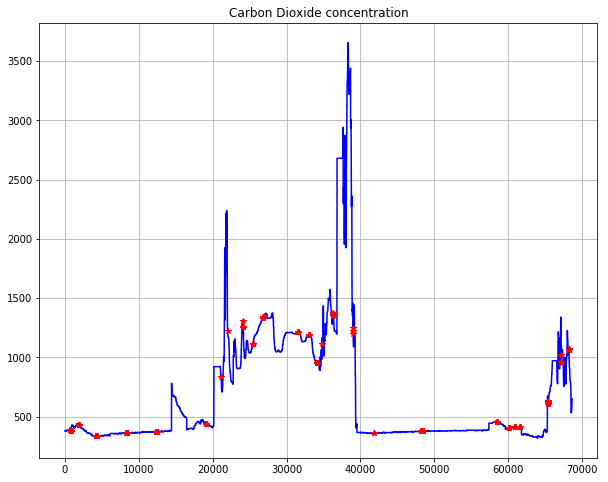

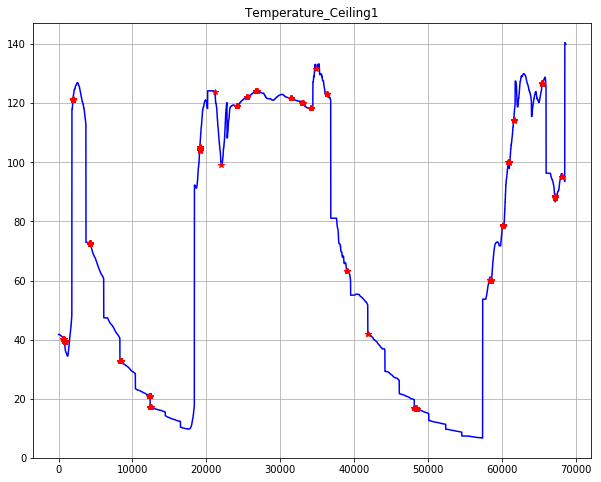

In [81]:
plot_events(g, bfp.values.T[good_features], bfp.columns[good_features])

In [65]:
events = pd.DataFrame(data=np.concatenate([g[0][:-3].reshape(-1,1), -g[2].reshape(-1,1)],axis=1),
             index=bfp.index[:-3], columns=['is_anomaly', 'neg_log_anomaly_score'])

In [98]:
bfp_mini = pd.DataFrame(bfp.values[:,good_features], columns = bfp.columns[good_features], index=bfp.index)

In [101]:
bfp_mini.shape

(68643, 3)

In [102]:
events.shape

(68640, 2)

In [103]:
pd.concat([bfp_mini[:-3], events],axis=1).to_csv('data/bfp6_with_anomaly_score.csv', index_label='Timestamps')